# Classification. Linear models and KNN

Ссылка для просмотра если в гите не будут отображаться ячейки:

https://nbviewer.org/github/Sekai-no-uragawa/RS-School/blob/main/5_classification_linear_knn/hw_classification.ipynb

In [731]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [732]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [733]:
from sklearn.exceptions import NotFittedError

In [734]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        
        return 1 / (1 + np.exp(- X @ weights))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        
        N, n = x.shape
        
        return np.sum(np.log((1 + np.exp(-(x @ weights) * y)))) / N + \
                    ((np.sum(np.square(weights))) ** 0.5) / (2 * self.C)
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, 
                                                      size=num_features) # random weight initialization
        
        self.loss_history = np.array([self.get_loss(X_ext, self.weights_, y)])
        for i in range(self.max_iter):
            logistic_func = (1 - 1 / (1 + np.exp(-y * (X_ext @ self.weights_))))[:, np.newaxis]
            delta = self.weights_ / self.C - np.sum(y[:, np.newaxis] * X_ext * logistic_func, axis=0) / y.shape[0]
            self.weights_ -= self.eta * delta
            self.loss_history = np.append(self.loss_history, self.get_loss(X_ext, self.weights_, y))
            if np.linalg.norm(self.eta * delta, 2) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return (self.predict_proba(X) > 0.5) * 2 - 1

In [735]:
from sklearn import datasets
from sklearn import metrics

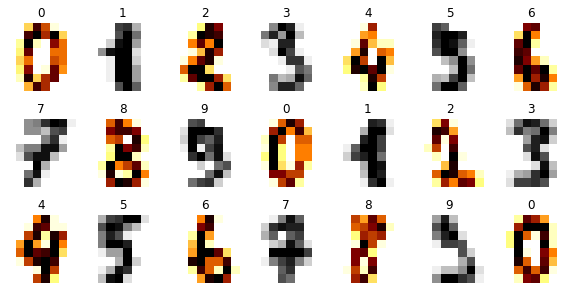

In [736]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [737]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [738]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [739]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [740]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [741]:
lr_clf.fit(X_train, y_train)

In [742]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [743]:
model = CustomLogisticRegression()

c:\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\8FEE~1\AppData\Local\Temp/ipykernel_8744/3460906950.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


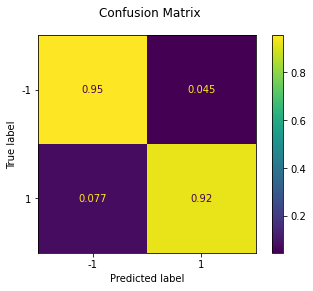

In [744]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [745]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [746]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

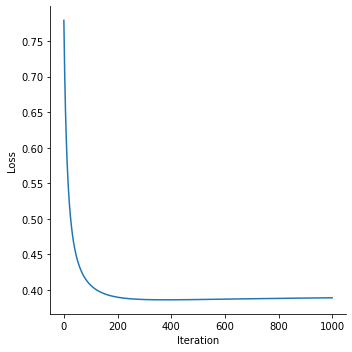

In [747]:
loss = sns.relplot(x=range(model.loss_history.shape[0]), y=model.loss_history, kind="line")
loss.set_ylabels("Loss")
loss.set_xlabels("Iteration")

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [748]:
clf = CustomLogisticRegression(eta=0.1)
clf.fit(X_train, y_train)
loss_hist = pd.DataFrame(clf.loss_history)
names = ['lr=0.1']
loss_hist.columns = names

for lr in np.geomspace(0.01, 0.00001, num=10):
    clf = CustomLogisticRegression(eta=lr)
    clf.fit(X_train, y_train)
    loss_hist = pd.concat([loss_hist, pd.DataFrame(clf.loss_history)], axis=1)
    names.append(f'lr={lr}')
    loss_hist.columns = names

Text(0.5, 0, 'Iteration')

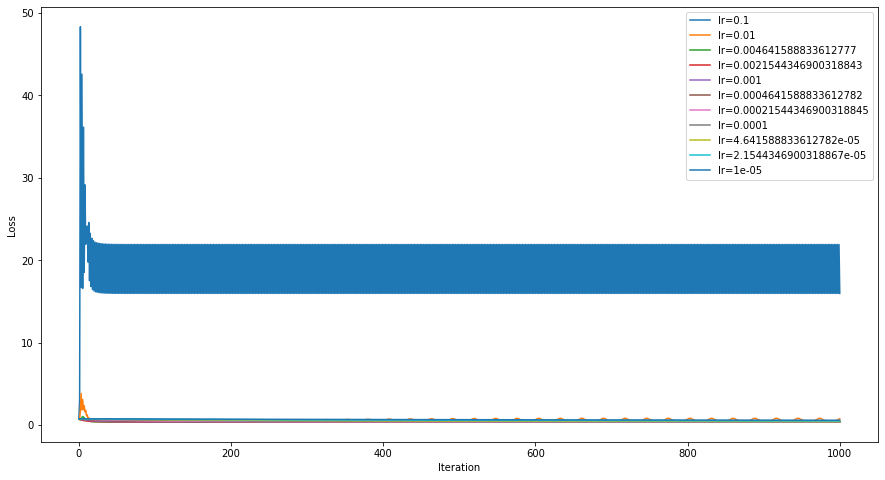

In [749]:
plt.figure(figsize=(15,8))
a = plt.plot(loss_hist)
plt.legend(a, loss_hist.columns.to_list())
plt.ylabel("Loss")
plt.xlabel("Iteration")


Видим, что при тета 0,1 огромный лос, приблизим

(0.0, 4.0)

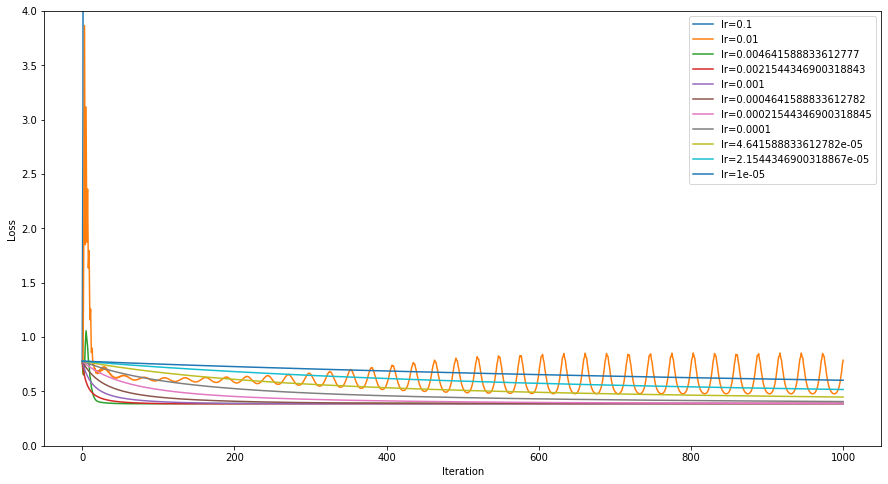

In [750]:
plt.figure(figsize=(15,8))
a = plt.plot(loss_hist)
plt.legend(a, loss_hist.columns.to_list())
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.ylim(0, 4)

Тета равная 0.01 все еще дает большой лос из-за того что "шаг" градиента получается слишком большой для нашей функции, приблизим еще

(0.0, 1.0)

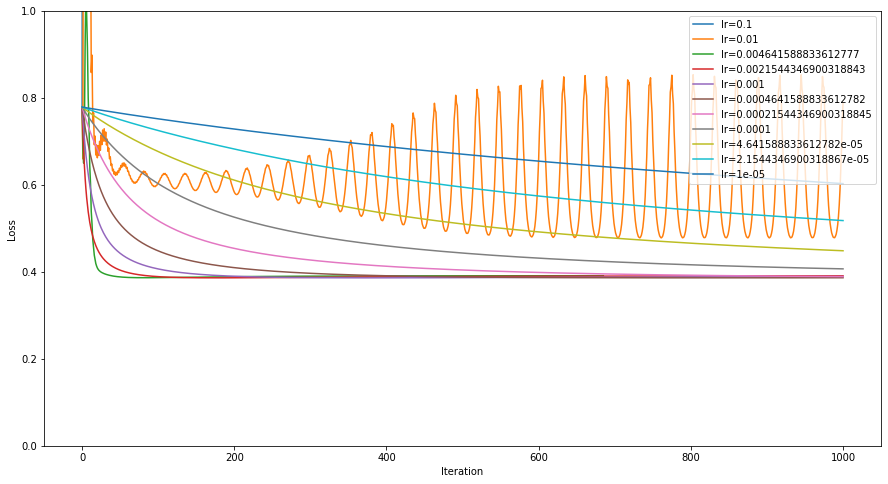

In [751]:
plt.figure(figsize=(15,8))
a = plt.plot(loss_hist)
plt.legend(a, loss_hist.columns.to_list())
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.ylim(0, 1)

Тут становится видно, что с уменьшением тета, примерно при lr = 0,0046 градиентный спуск быстрее всего оказывается в минимуме функции и дальше из минимума не выходит, с последующим уменьшением длины шага увеличивается время нахождения минимума. В общем случае, слишком большой lr приводит к "перескакиванию" минимума, а слишком маленький - к долгому схождению.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [752]:
clf = CustomLogisticRegression(C=1000.0)
clf.fit(X_train, y_train)
loss_hist = pd.DataFrame(clf.loss_history)
accuracy = pd.DataFrame([metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
                         metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)])
names = ['С=1000']
loss_hist.columns = names
accuracy.columns = names

for c in np.logspace(2, -1, num=7):
    clf = CustomLogisticRegression(C=c)
    clf.fit(X_train, y_train)
    loss_hist = pd.concat([loss_hist, pd.DataFrame(clf.loss_history)], axis=1)
    accuracy = pd.concat([accuracy, pd.DataFrame([metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
                                                  metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)])], axis=1)
    names.append(f'C={c}')
    loss_hist.columns = names
    accuracy.columns = names

(0.2, 1.1)

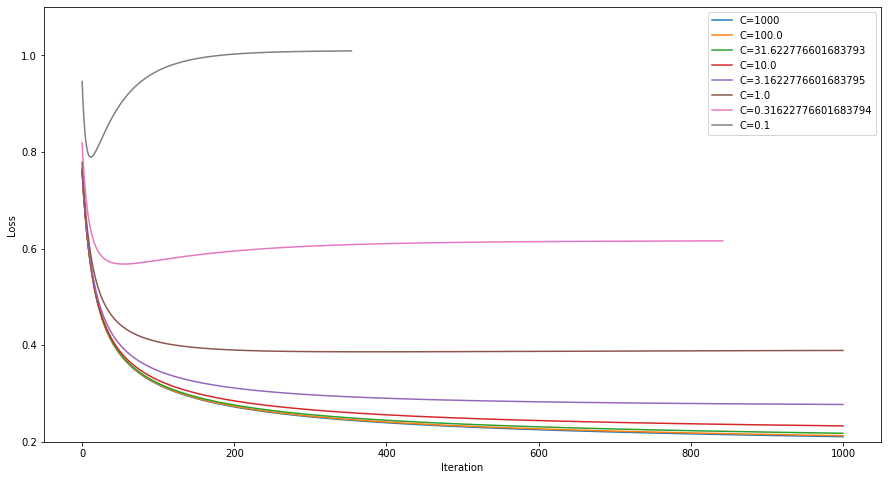

In [753]:
plt.figure(figsize=(15,8))
a = plt.plot(loss_hist)
plt.legend(a, loss_hist.columns.to_list())
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.ylim(0.2, 1.1)

Видно, что при достаточно большом С loss начинает принимать все меньшие значения, значит что у градиентного спуска получается все ближе подобраться к минимуму за счет уменьшения весов, ведь С не что иное, как штраф за величину весов модели.

Посмотрим на accuracy при этих же С

In [754]:
accuracy

,С=1000,C=100.0,C=31.622776601683793,C=10.0,C=3.1622776601683795,C=1.0,C=0.31622776601683794,C=0.1
0,0.914405,0.914405,0.914405,0.915101,0.915101,0.910926,0.897008,0.887265
1,0.941667,0.941667,0.941667,0.941667,0.944444,0.938889,0.916667,0.913889


(0.8, 1.1)

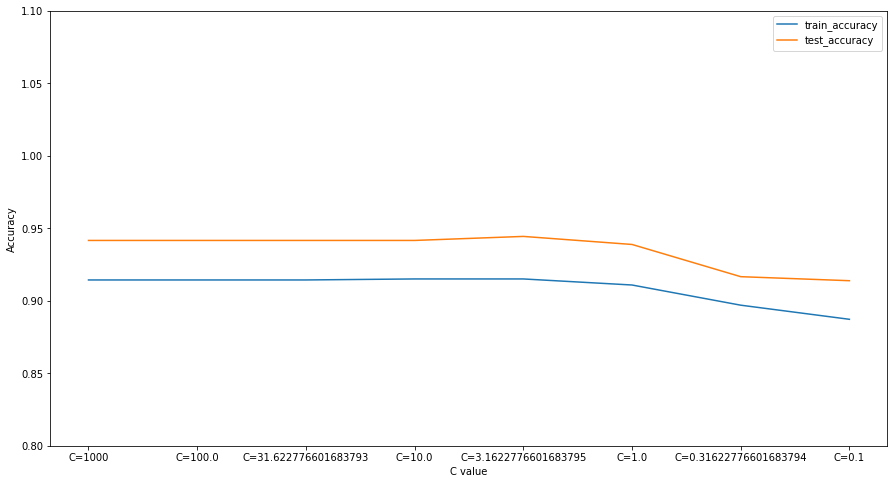

In [755]:
plt.figure(figsize=(15,8))
a = plt.plot(accuracy.T)
plt.legend(a, ['train_accuracy', 'test_accuracy'])
plt.ylabel("Accuracy")
plt.xlabel("C value")
plt.ylim(0.8, 1.1)

**(0.5 points)** Compare zero initialization and random initialization. 

In [756]:
clf = CustomLogisticRegression(zero_init=True)
clf.fit(X_train, y_train)
loss_hist = pd.DataFrame(clf.loss_history)
names = ['zero_init=True']
loss_hist.columns = names

clf = CustomLogisticRegression(zero_init=False)
clf.fit(X_train, y_train)
loss_hist = pd.concat([loss_hist, pd.DataFrame(clf.loss_history)], axis=1)
names.append('zero_init=False')
loss_hist.columns = names

(0.2, 1.1)

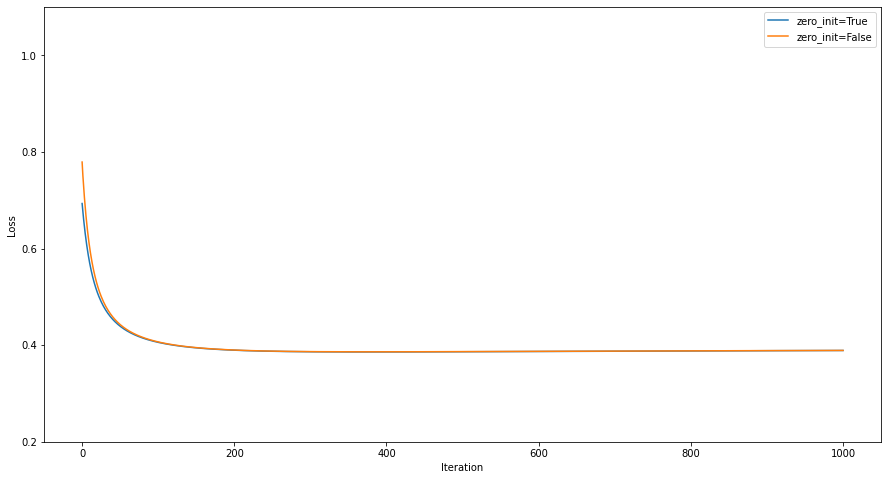

In [757]:
plt.figure(figsize=(15,8))
a = plt.plot(loss_hist)
plt.legend(a, loss_hist.columns.to_list())
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.ylim(0.2, 1.1)

Видно, что вся разница будет в районе первых итераций, т.к. и разница будет заключаться только в стартовой точке. Либо она выпадет немного дальше от минимума, либо ближе к нему, но в ходе градиентного спуска вся разница довольно быстро нивелируется.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [758]:
from sklearn.metrics import pairwise_distances

In [759]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return pairwise_distances(X, Y)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        weights_sum = pd.DataFrame({'class': y, 'weights': weights}).groupby(by='class').sum()
        return pd.DataFrame(weights_sum, self.classes_).values.reshape(-1).tolist()
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """

        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            final_proba = []

            if self.weights == 'distance':
                weights = 1 / (P + self.eps)
                weights_of_points = np.zeros_like(P)

                for i in range(weights.shape[0]):
                    for j in np.argsort(-weights[i])[0:self.n_neighbors]:
                        weights_of_points[i][j] = weights[i][j]

                class_proba = np.asarray([self.get_class_weights(self.y, weights_of_points[i]) for i in range(weights_of_points.shape[0])])
                for i in range(class_proba.shape[0]):
                    final_proba.append([class_proba[i][j] / np.sum(class_proba[i]) for j in range(class_proba.shape[1])])
                return np.asarray(final_proba)

            if self.weights == 'uniform':
                weights_of_points = np.zeros_like(P)
                
                for i in range(P.shape[0]):
                    for j in np.argsort(P[i])[0:self.n_neighbors]:
                        weights_of_points[i][j] = 1
                class_proba = np.asarray([self.get_class_weights(self.y, weights_of_points[i]) \
                                          for i in range(weights_of_points.shape[0])])

                for i in range(class_proba.shape[0]):
                    final_proba.append([class_proba[i][j] / np.sum(class_proba[i]) for j in range(class_proba.shape[1])])
                return np.asarray(final_proba)

        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        pr = self.predict_proba(X)
        
        ans = []
        for row in pr:
            for num, ind in enumerate(row):
                if row.max() == ind:
                    ans.append(num)
        
        return ans

In [760]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [761]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [762]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

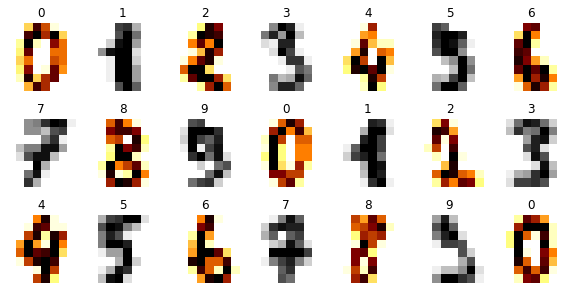

In [763]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [764]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [765]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

c:\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\8FEE~1\AppData\Local\Temp/ipykernel_8744/3460906950.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


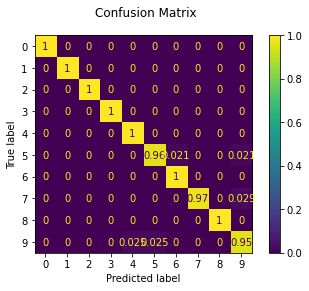

In [766]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [767]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Путает (5 c 6 и 9), (7 с 9), а также (9 с 4 и 5) из-за общей схожести цифр (наличии большого количества похожих элементов в них)

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [768]:
accuracy_hist = pd.DataFrame(columns=['n_neighbors', 'Accuracy'])
for n in range(1, 101):
    clf = CustomKNeighborsClassifier(n_neighbors=n, weights='distance')
    clf.fit(X_train, y_train)
    accuracy_hist = accuracy_hist.append({'n_neighbors':n, 'Accuracy':accuracy_score(y_test, clf.predict(X_test))}, ignore_index=True)

In [769]:
accuracy_hist

,n_neighbors,Accuracy
0,1.0,0.977778
1,2.0,0.977778
2,3.0,0.983333
3,4.0,0.983333
4,5.0,0.986111
...,...,...
95,96.0,0.944444
96,97.0,0.941667
97,98.0,0.941667
98,99.0,0.941667


(0.9, 1.0)

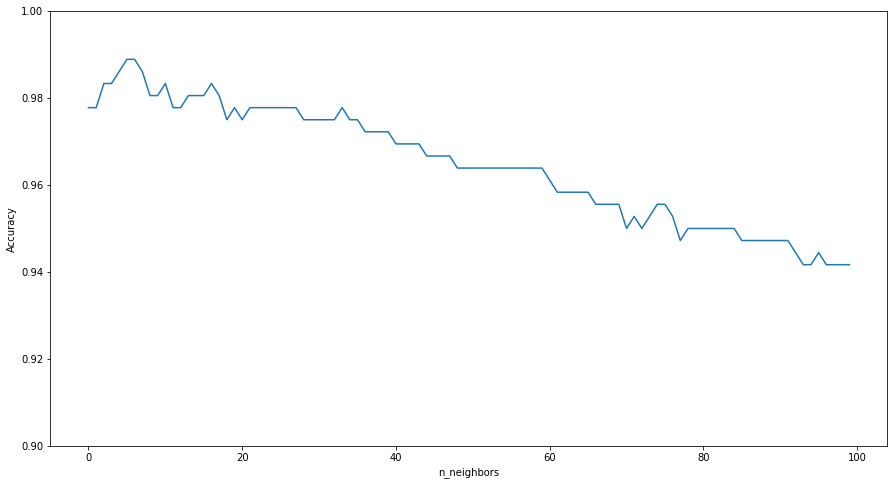

In [770]:
plt.figure(figsize=(15,8))
a = plt.plot(accuracy_hist['Accuracy'])
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.ylim(0.9, 1)

С увеличением числа соседей обобщающее свойство модели падает и точность немного уменьшается

При этом максимальная точность достигается при:

In [771]:
accuracy_hist[accuracy_hist.Accuracy == accuracy_hist.Accuracy.max()]

,n_neighbors,Accuracy
5,6.0,0.988889
6,7.0,0.988889


**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

c:\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\8FEE~1\AppData\Local\Temp/ipykernel_8744/3460906950.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


weights="distance" 
 Train accuracy: 1.0 
 Test accuracy: 0.9861111111111112


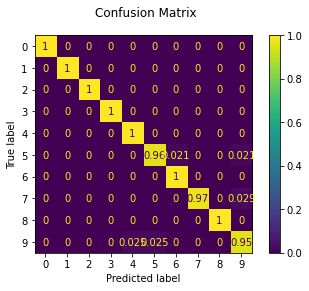

In [772]:
model = KNeighborsClassifier(n_neighbors=5, weights='distance')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('weights="distance"','\n','Train accuracy:', train_acc,'\n','Test accuracy:', test_acc)

c:\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\8FEE~1\AppData\Local\Temp/ipykernel_8744/3460906950.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


weights="uniform" 
 Train accuracy: 0.9895615866388309 
 Test accuracy: 0.9861111111111112


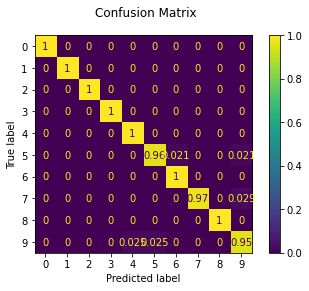

In [773]:
model = KNeighborsClassifier(n_neighbors=5, weights='uniform')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('weights="uniform"','\n','Train accuracy:', train_acc,'\n','Test accuracy:', test_acc)

Точность на Train упала. При uniform чаще будут попадаться одинаковые вероятности и как следствие неправильная классификация, distance в это нивелирует

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

Возможно Чебышевское расстояние действовало бы немного лучше, если пробовать использовать его, то появляются неточности только в очень похожих цифрах: 9 и 8, 3 и 8. Но в целом, евклидово растояние скорее всего лучшее для данной задачи

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Предложу задачу какой-либо классификации людей по их параметрам: росту, весу и т.д.

В этом случае, при использовании стандартной метрики(Евклидовой):

Например, двумерные образцы (рост [единица измерения: см], вес [единица измерения: кг]), существует три образца: a (180, 50), b (190, 50), c (180, 60). Тогда минимальное расстояние a и b равно минимальному расстоянию a и c. Но на самом деле 10 см в высоту не может сравниться с 10 кг в весе.

Для этой задачи подойдет нормализованное расстояние Евклида. Идея стандартного евклидова расстояния: поскольку распределение компонентов в каждом измерении данных не одинаково, прежде всего «нормализуйте» каждый компонент к среднему значению и дисперсии. 

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [985]:
df = pd.read_csv('train.csv').set_index('PassengerId')

In [986]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [987]:
from pandas_profiling import ProfileReport

In [988]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [989]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Assessment of the relationship between each variable and the target variable

#### Relationship between Survived and Sex

<AxesSubplot:xlabel='Survived', ylabel='count'>

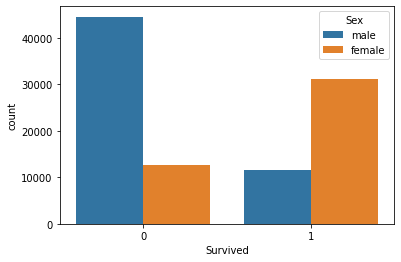

In [990]:
sns.countplot(x='Survived', hue='Sex', data=df)

#### Relationship between Survived and SibSp

<AxesSubplot:xlabel='SibSp', ylabel='count'>

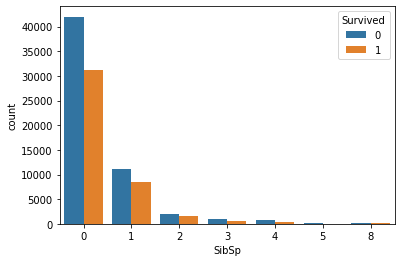

In [991]:
sns.countplot(x='SibSp', hue='Survived', data=df)

#### Relationship between Survived and Parch

<AxesSubplot:xlabel='Parch', ylabel='count'>

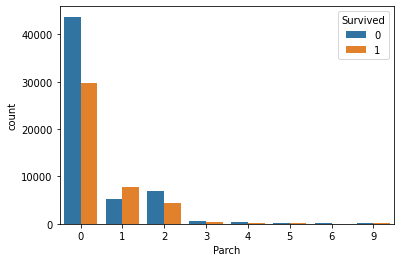

In [992]:
sns.countplot(x='Parch', hue='Survived', data=df)

Введем новый признак Family, являющийся суммой признаков Parch и SibSp

In [993]:
df['Family'] = df.Parch + df.SibSp

<AxesSubplot:xlabel='Family', ylabel='count'>

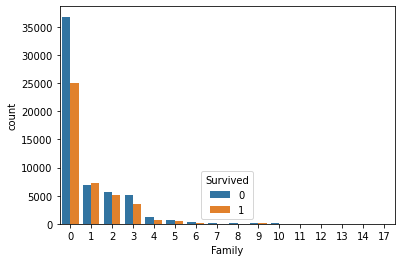

In [994]:
sns.countplot(x='Family', hue='Survived', data=df)

Видна небольшая зависимость выживаемости от наличия семьи - у людей без родственников отслеживается явно меньший процент выживаемости, чем у людей с семьей.

Разделим пассажиров по парамметру Family на две категории:

    0 - без семьи
    1 - с семьей

In [995]:
df.loc[df['Family'] != 0, 'Family'] = 1
df.loc[df['Family'] == 0, 'Family'] = 0

<AxesSubplot:xlabel='Family', ylabel='count'>

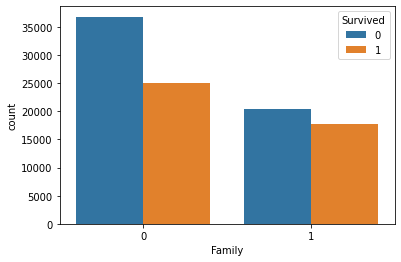

In [996]:
sns.countplot(x='Family', hue='Survived', data=df)

<AxesSubplot:xlabel='Family', ylabel='Survived'>

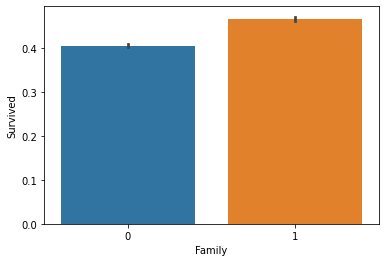

In [997]:
sns.barplot(x='Family', y='Survived', data=df)

Присутствие родственников в целом дает небольшой шанс выживаемости, но, если посмотреть на связь в разрезе по классам и полу, то картина меняется.

c:\python38\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


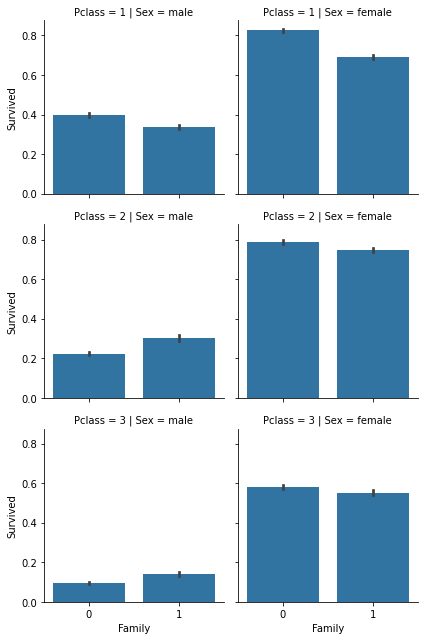

In [998]:
g = sns.FacetGrid(data=df, row='Pclass', col='Sex')
g.map(sns.barplot, 'Family', 'Survived')

Отсутствие семьи у женщин во всех классах дает небольшую прибавку к выживаемости. У мужчин аналогично для первого класса, а для 2 и 3 - отсутствие семьи ведет к ухудшению выживаемости.

#### Relationship between Survived and Fare

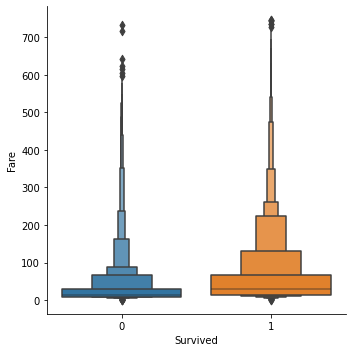

In [999]:
sns.catplot(kind="boxen", y='Fare', x='Survived', data=df)

Видно, что путешествующие за более низкую стоимость пассажиры выживале реже, чем за более высокую

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

#### Relationship between Survived and Age

<AxesSubplot:xlabel='Survived', ylabel='Age'>

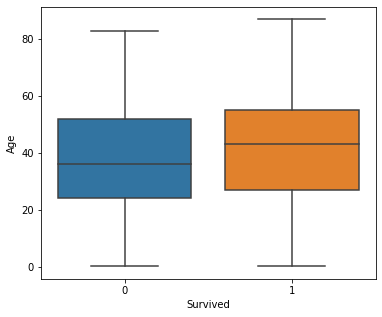

In [1000]:
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x='Survived', y='Age')

#### Разделим колонку Age на 3 категории: Child (0) - до 16 лет, Adult (1) - 16 <= Adult < 45, и Old (2) - старше 45, при этом заменим отсутствующие значения Age на среднне значение из той же группы по категориям Pclass и Sex

In [1001]:
for sex in ['male', 'female']:
    for pclass in range (1,4):
        df.loc[(df['Pclass'] == pclass) & (df.Sex == sex) & (df.Age.isnull()), 'Age'] = \
        df[(df['Pclass'] == pclass) & (df["Sex"] == sex)].Age.mean().round()     

In [1002]:
df.Age.isna().any()

False

In [1003]:
df['Age_group'] = df['Age']

<AxesSubplot:xlabel='Age_group', ylabel='count'>

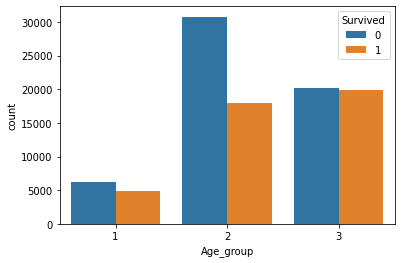

In [1004]:
def age_group(x):
    if x < 16:
        return 1
    elif x < 45:
        return 2
    else: return 3
df['Age_group'] = df.Age_group.apply(lambda x: age_group(x))
sns.countplot(hue='Survived', x=df['Age_group'], data=df)

**Вывод:** Если ты взрослый, то выжить шансов практически в два раза меньше чем погибнуть. У детей или людей старшего поколения шансы на выживание почти 50 на 50.

 **(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

#### Relationship between Survived and Pclass

<AxesSubplot:xlabel='Pclass', ylabel='count'>

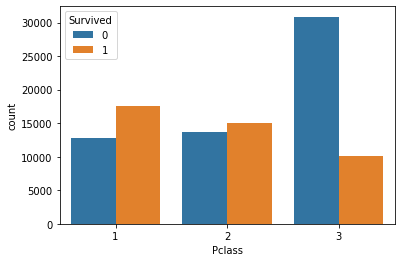

In [1005]:
sns.countplot(x='Pclass', hue='Survived', data=df)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

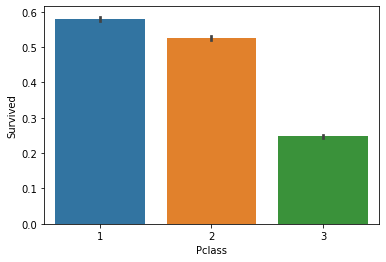

In [1006]:
sns.barplot(x='Pclass', y='Survived', data=df)

**Вывод:** В третьем классе шанс выжить самый низкий

#### Relationship between Survived and Embarked

<AxesSubplot:xlabel='Embarked', ylabel='count'>

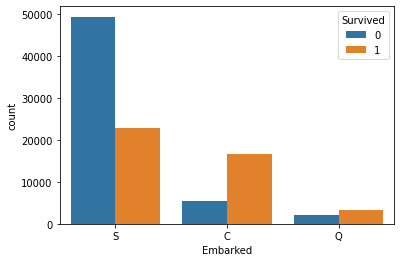

In [1007]:
sns.countplot(x='Embarked', hue='Survived', data=df)

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

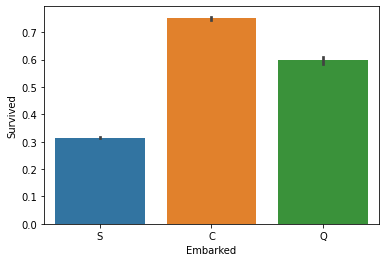

In [1008]:
sns.barplot(x='Embarked', y='Survived', data=df)

Видна взаимосвязь между портом посадки - севшие в месте отправления - S - имели меньше шансов выжить, чем остальные.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [1016]:
print('Пропущено в %')
df.isna().sum() / df.shape[0] * 100

Пропущено в %


Survived      0.000
Pclass        0.000
Name          0.000
Sex           0.000
Age           0.000
SibSp         0.000
Parch         0.000
Ticket        4.623
Fare          0.134
Cabin        67.866
Embarked      0.250
Family        0.000
Age_group     0.000
dtype: float64

In [1017]:
print((df.isna().sum().sum() / 11000).round(3),'% - процентов всех данных пропущено')

6.625 % - процентов всех данных пропущено


<AxesSubplot:>

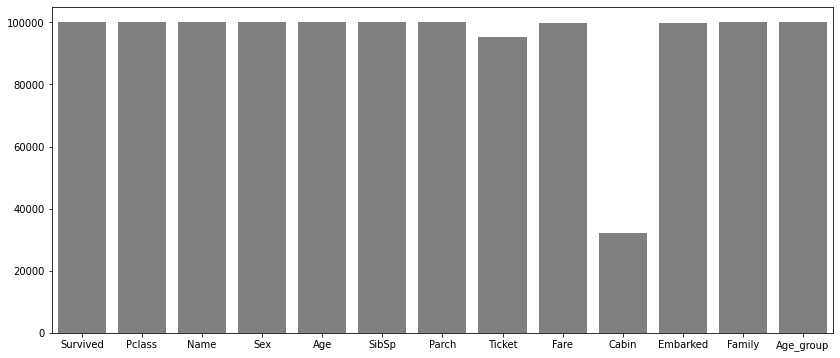

In [1018]:
new_df = df
new_df = new_df.notnull().sum()
plt.figure(figsize=(14,6))
sns.barplot(y=new_df.values, x=new_df.index, color='gray', )

Пропуски меются в стобцах Ticket, Fare, Cabin, Embarked. Данных из столбца **Cabin** имеется только треть

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Пропущенные значения в Fare заменим медианой (устойчива к выбросам), Ticket не будем использовать, оригинальную колонку Cabin тоже, из нее получим информацию известен ли номер или нет (рассматривалось выше), Embarked заполним самым частым значением.

Попробую обучить с новой колонкой Age_group вместо Age и без нее, аналогично с Family

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [1019]:
data = df.copy()

In [1020]:
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Age_group
PassengerId,,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,42.00,2,0,209245,27.14,C12239,S,1,2
1,0,3,"Bryan, Drew",male,34.00,0,0,27323,13.35,NaN,S,0,2
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S,1,1
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S,0,2
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C,0,3
99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S,0,3
99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S,0,2


In [1021]:
data.loc[data.Fare.isna(), 'Fare'] = data.median(axis=0).Fare

C:\Users\8FEE~1\AppData\Local\Temp/ipykernel_8744/3370776340.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.loc[data.Fare.isna(), 'Fare'] = data.median(axis=0).Fare


In [1022]:
data.loc[data.Cabin.notna(), 'Cabin'] = 1
data.loc[data.Cabin.isna(), 'Cabin'] = 0

In [1023]:
data.loc[data.Embarked.isna(), 'Embarked'] = 'S'

In [1024]:
data = data.drop(['Ticket', 'Name', ], axis=1)#'Age','SibSp','Parch'

In [1025]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family,Age_group
PassengerId,,,,,,,,,,,
0,1,1,male,42.00,2,0,27.14,1,S,1,2
1,0,3,male,34.00,0,0,13.35,0,S,0,2
2,0,3,male,0.33,1,2,71.29,0,S,1,1
3,0,3,male,19.00,0,0,13.04,0,S,0,2
4,1,3,male,25.00,0,0,7.76,0,S,0,2


In [1026]:
y = data.Survived

In [1027]:
X = data.drop(['Survived'], axis=1)

Разделение на треин и тест, пайплайн и обучение моделей

In [1028]:
rand = 42

In [1029]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=rand)

In [1030]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family,Age_group
PassengerId,,,,,,,,,,
75220,1,male,45.0,1,2,65.33,1,S,1,3
48955,1,female,60.0,0,0,431.43,1,Q,0,3
44966,3,male,33.0,0,0,19.70,0,S,0,2
13568,3,male,35.0,0,0,6.85,0,S,0,2
92727,1,female,30.0,0,0,20.37,0,C,0,2
...,...,...,...,...,...,...,...,...,...,...
6265,2,male,19.0,0,0,9.43,0,S,0,2
54886,2,male,43.0,1,1,21.00,0,S,1,2
76820,1,female,46.0,1,2,72.47,1,S,1,3


In [1031]:
# pipeline = Pipeline([
#         ('column_trans', ColumnTransformer(
#             [('sca', StandardScaler(), ['Age', 'Fare']),
#              ('OHE', OneHotEncoder(), ['Pclass','Sex','SibSp','Parch','Cabin','Embarked'])],
#              remainder='passthrough')), 
#         ('clf', LogisticRegression())
#     ])

#2 вариант

pipeline = Pipeline([
        ('column_trans', ColumnTransformer(
            [('sca', StandardScaler(), ['Fare', 'Age']),
             ('OHE', OneHotEncoder(), ['Pclass','Sex','SibSp','Parch','Cabin','Embarked','Family','Age_group'])],
             remainder='passthrough')), 
        ('clf', LogisticRegression(max_iter=2000, C=0.01, penalty='l1', solver='saga'))
    ])

In [1032]:
pipeline.fit(X, y)

Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('sca', StandardScaler(),
                                                  ['Fare', 'Age']),
                                                 ('OHE', OneHotEncoder(),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Cabin', 'Embarked',
                                                   'Family', 'Age_group'])])),
                ('clf',
                 LogisticRegression(C=0.01, max_iter=2000, penalty='l1',
                                    solver='saga'))])

In [1033]:
pipeline.score(X_test, y_test)

0.76745

In [1034]:
param_grid = {'clf__C': [100, 10, 1, 0.1, 0.01, 0.001], 
              'clf__max_iter': [2000], 
              'clf__solver' : ['saga', 'lbfgs'],
              'clf__penalty' : ['l1', 'l2', 'elasticnet', 'none']
             }

# Выполняется долго, при желании раскомментить
# Ошибки сыпет из-за несовместимости некоторых штрафом с методом решения
#search = GridSearchCV(pipeline, 
                      param_grid, 
                      scoring='accuracy',
                      cv=5)

search.fit(X, y)

c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\python3

c:\python38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\python38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\python38\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\python38\lib\site-packages\sk

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('sca',
                                                                         StandardScaler(),
                                                                         ['Fare',
                                                                          'Age']),
                                                                        ('OHE',
                                                                         OneHotEncoder(),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'SibSp',
                                                                          'Parch',
     

In [1035]:
search.best_params_

{'clf__C': 0.01,
 'clf__max_iter': 2000,
 'clf__penalty': 'l2',
 'clf__solver': 'saga'}

In [1036]:
search.best_score_

0.76835

КНН

In [1037]:
knn_pipe = Pipeline([
        ('column_trans', ColumnTransformer(
            [('sca', StandardScaler(), ['Fare', 'Age']),
             ('OHE', OneHotEncoder(), ['Pclass','Sex','SibSp','Parch','Cabin','Embarked','Family','Age_group'])],
             remainder='passthrough')), 
        ('clf', KNeighborsClassifier(n_neighbors=1, weights='distance',))
    ])

In [1038]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('sca', StandardScaler(),
                                                  ['Fare', 'Age']),
                                                 ('OHE', OneHotEncoder(),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Cabin', 'Embarked',
                                                   'Family', 'Age_group'])])),
                ('clf',
                 KNeighborsClassifier(n_neighbors=1, weights='distance'))])

In [1039]:
knn_pipe.score(X_test, y_test)

0.69345

Результаты какие-то не очень, попробую немного другие фичи и использую оптуну для подбора параметров.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [1040]:
train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')

In [1041]:
train['Embarked'] = train['Embarked'].fillna('S')
test['Embarked'] = test['Embarked'].fillna('S')

train['Cabin'] = train['Cabin'].fillna('_')
test['Cabin'] = test['Cabin'].fillna('_')

train.Ticket = train.Ticket.map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')
test.Ticket = test.Ticket.map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')

train['CabinType'] = train['Cabin'].apply(lambda x:x[0])
test['CabinType'] = test['Cabin'].apply(lambda x:x[0])

train['Age'].fillna(round(train['Age'].median()), inplace=True,)
test['Age'].fillna(round(test['Age'].median()), inplace=True,)
train['Age'] = train['Age'].apply(round)
test['Age'] = test['Age'].apply(round)
train['Age'] = train['Age'].astype(np.int8)
test['Age'] = test['Age'].astype(np.int8)


train['Fare'].fillna(round(train['Fare'].mean()), inplace=True,)
test['Fare'].fillna(round(test['Fare'].mean()), inplace=True,)

train['FirstName'] = train['Name'].apply(lambda x:x.split(', ')[0])
train['SecondName'] = train['Name'].apply(lambda x:x.split(', ')[1])

test['FirstName'] = test['Name'].apply(lambda x:x.split(', ')[0])
test['SecondName'] = test['Name'].apply(lambda x:x.split(', ')[1])

train['n'] = 1
test['n'] = 1

gb = train.groupby('FirstName')
df_names = gb['n'].sum()
train['SameFirstName'] = train['FirstName'].apply(lambda x:df_names[x])

gb = test.groupby('FirstName')
df_names = gb['n'].sum()
test['SameFirstName'] = test['FirstName'].apply(lambda x:df_names[x])

train['SameFirstName'] = train['SameFirstName'].apply(lambda x:-1 if x>10 else x)
test['SameFirstName'] = test['SameFirstName'].apply(lambda x:-1 if x>10 else x)

###
train['Family'] = train.Parch + train.SibSp
test['Family'] = test.Parch + test.SibSp

train.loc[train['Family'] != 0, 'Family'] = 1
train.loc[train['Family'] == 0, 'Family'] = 0

test.loc[test['Family'] != 0, 'Family'] = 1
test.loc[test['Family'] == 0, 'Family'] = 0


In [1042]:
target = 'Survived'
columns = ['Pclass', 'Sex', 'Age', 'Embarked', 'Fare', 'CabinType', 'Ticket', 'SameFirstName', 'Family']
cat_features = ['Pclass', 'Sex', 'Embarked', 'CabinType', 'Ticket', 'Family']
num_features = ['Age', 'Fare', 'SameFirstName']

In [1053]:
train[columns]

,Pclass,Sex,Age,Embarked,Fare,CabinType,Ticket,SameFirstName,Family
PassengerId,,,,,,,,,
0,1,male,39,S,27.14,C,X,-1,1
1,3,male,39,S,13.35,_,X,-1,0
2,3,male,0,S,71.29,_,CA,-1,1
3,3,male,19,S,13.04,_,A.,-1,0
4,3,male,25,S,7.76,_,X,-1,0
...,...,...,...,...,...,...,...,...,...
99995,2,female,62,C,14.86,D,PC,-1,0
99996,2,male,66,S,11.15,_,X,-1,0
99997,3,male,37,S,9.95,_,X,10,0


In [1054]:
train[columns].nunique()

Pclass               3
Sex                  2
Age                 88
Embarked             3
Fare             15935
CabinType            9
Ticket              50
SameFirstName       11
Family               2
dtype: int64

In [1055]:
pipe_transform = Pipeline([
    ('ColumnTransformer', ColumnTransformer(
            [('sca', StandardScaler(), num_features),
             ('OHE', OneHotEncoder(), cat_features)],
             remainder='passthrough')
    ),
])

## v2

In [856]:
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)

In [857]:
enc_df = train[label_features].apply(label_encoder)
numerical_df = train[num_features]

In [858]:
scaler = StandardScaler()
numerical_df = pd.DataFrame(scaler.fit_transform(train[num_features]), columns=num_features)

In [859]:
train = pd.concat([enc_df, numerical_df, train[['Pclass', 'Family']], train['Survived']], axis=1)

In [860]:
train.drop('Survived', axis=1)

,Sex,Embarked,Age,Parch,SibSp,Fare,SameFirstName,Pclass,Family
0,1,3,-0.019072,-0.478448,1.857618,-0.241429,-0.763656,1,1
1,1,3,-0.019072,-0.478448,-0.461057,-0.439727,-0.763656,3,0
2,1,3,-2.128967,1.626657,0.698280,0.393441,-0.763656,3,1
3,1,3,-1.074019,-0.478448,-0.461057,-0.444185,-0.763656,3,0
4,1,3,-0.740878,-0.478448,-0.461057,-0.520110,-0.763656,3,0
...,...,...,...,...,...,...,...,...,...
99995,0,0,1.313494,-0.478448,-0.461057,-0.418014,-0.763656,2,0
99996,1,3,1.535588,-0.478448,-0.461057,-0.471363,-0.763656,2,0
99997,1,3,-0.074595,-0.478448,-0.461057,-0.488618,2.988251,3,0
99998,1,3,0.702735,0.574104,-0.461057,-0.187073,0.259591,3,1


<AxesSubplot:>

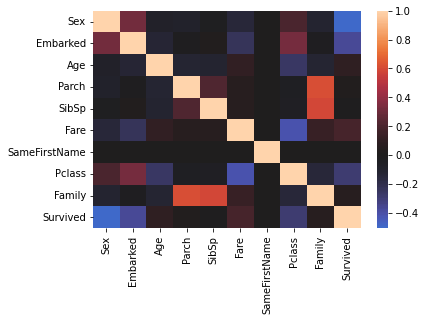

In [861]:
sns.heatmap(train.corr(), center=0)


In [791]:
X_tr = train.drop('Survived', axis=1)#[columns]
y_tr = train[target]

In [792]:
enc_df_test = test[label_features].apply(label_encoder)
numerical_df = pd.DataFrame(scaler.transform(test[num_features]), columns=num_features)
X_test = pd.concat([enc_df_test.reset_index(drop=True), numerical_df, test['Pclass'].reset_index(drop=True)], axis=1)

In [722]:
enc_df_test = test[label_features].apply(label_encoder)
numerical_df = test[num_features]
X_test = pd.concat([enc_df_test.reset_index(drop=True), numerical_df.reset_index(drop=True), test['Pclass'].reset_index(drop=True)], axis=1)

In [793]:
X_test

,Sex,Embarked,Age,Parch,SibSp,Fare,SameFirstName,Pclass
0,1,3,-1.074019,-0.478448,-0.461057,0.274375,2.647169,3
1,0,3,0.813782,-0.478448,-0.461057,-0.548151,-0.763656,3
2,0,0,-1.074019,-0.478448,-0.461057,-0.072178,-0.763656,1
3,1,3,-0.740878,-0.478448,-0.461057,-0.445767,-0.763656,2
4,0,0,-1.185067,1.626657,-0.461057,-0.245024,1.623921,1
...,...,...,...,...,...,...,...,...
99995,0,2,-0.629831,-0.478448,-0.461057,-0.486174,-0.763656,3
99996,1,3,1.146923,-0.478448,0.698280,0.350589,-0.763656,1
99997,1,3,0.480640,-0.478448,-0.461057,-0.475389,0.259591,3
99998,0,0,0.591687,1.626657,0.698280,-0.204904,1.965004,1


 #############
 

In [1056]:
X_tr = train[columns]
y_tr = train[target]
X_test = test[columns]

In [1057]:
X_train_transform = pipe_transform.fit_transform(X_tr)
X_test_transform = pipe_transform.transform(X_test)

In [1058]:
X_train, X_val, y_train, y_val = train_test_split(X_train_transform, y_tr, random_state=42)

In [1062]:
clf = LogisticRegressionCV(max_iter=2000)

In [1063]:
clf.fit(X_train, y_train)

LogisticRegressionCV(max_iter=2000)

In [1064]:
clf.score(X_val, y_val)

0.76996

### Optuna

Подберем гиперпараметры

In [952]:
import optuna

def objective(trial):
    # hyperparameter setting
    param = {
        'C': trial.suggest_float('C', 0.00001, 100, log=True),
        'max_iter': trial.suggest_int('max_iter', 1000, 5000),
        'solver': trial.suggest_categorical('solver', ['saga', 'lbfgs', 'newton-cg']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'none'])
    }
    
    if param['solver'] == 'lbfgs':
        param['penalty'] = 'l2'
    if param['solver'] == 'newton-cg':
        param['penalty'] = 'l2'
    
    if param['penalty'] == 'elasticnet':
        param['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)
    
    # data loading and train-test spliе
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_transform, y_tr, random_state=42)
    
    # model training and evaluation
    model = LogisticRegression(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    error = accuracy_score(y_val, y_pred)

    # output: evaluation score
    return error

In [953]:
# Поиск также долгий
#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=1000, timeout=2000, catch=(Exception,))

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-04-04 14:21:42,649] A new study created in memory with name: no-name-90dbedfe-8acb-4437-8735-855adcb0e80f
[I 2022-04-04 14:21:43,932] Trial 0 finished with value: 0.76988 and parameters: {'C': 8.531568085479972, 'max_iter': 2468, 'solver': 'newton-cg', 'penalty': 'l2', 'class_weight': 'none'}. Best is trial 0 with value: 0.76988.
[I 2022-04-04 14:21:44,060] Trial 1 finished with value: 0.76568 and parameters: {'C': 0.00035998220510108814, 'max_iter': 1329, 'solver': 'lbfgs', 'penalty': 'elasticnet', 'class_weight': 'none'}. Best is trial 0 with value: 0.76988.
[I 2022-04-04 14:21:44,611] Trial 2 finished with value: 0.76852 and parameters: {'C': 0.007045783771901182, 'max_iter': 2106, 'solver': 'newton-cg', 'penalty': 'none', 'class_weight': 'none'}. Best is trial 0 with value: 0.76988.
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2022-04-04 14:21:51,376] T

[I 2022-04-04 14:24:32,385] Trial 31 finished with value: 0.77392 and parameters: {'C': 16.76649355052615, 'max_iter': 3504, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 17 with value: 0.774.
[I 2022-04-04 14:24:33,401] Trial 32 finished with value: 0.77392 and parameters: {'C': 0.10909186756546314, 'max_iter': 3953, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 17 with value: 0.774.
[I 2022-04-04 14:24:33,988] Trial 33 finished with value: 0.77304 and parameters: {'C': 0.012131979746359853, 'max_iter': 3502, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 17 with value: 0.774.
[I 2022-04-04 14:24:45,426] Trial 34 finished with value: 0.76984 and parameters: {'C': 4.858010423200774, 'max_iter': 2687, 'solver': 'saga', 'penalty': 'elasticnet', 'class_weight': 'none', 'l1_ratio': 0.10357791263950167}. Best is trial 17 with value: 0.774.
[I 2022-04-04 14:24:47,995] Trial 35 finished with value: 

[I 2022-04-04 14:27:50,969] Trial 64 finished with value: 0.77396 and parameters: {'C': 1.108948787414957, 'max_iter': 3768, 'solver': 'lbfgs', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 51 with value: 0.77404.
[I 2022-04-04 14:28:23,196] Trial 65 finished with value: 0.774 and parameters: {'C': 9.328934609636407, 'max_iter': 2153, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 51 with value: 0.77404.
[I 2022-04-04 14:29:20,834] Trial 66 finished with value: 0.77392 and parameters: {'C': 32.110942037865144, 'max_iter': 3938, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 51 with value: 0.77404.
[I 2022-04-04 14:29:32,672] Trial 67 finished with value: 0.77396 and parameters: {'C': 3.008015145981476, 'max_iter': 3276, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 51 with value: 0.77404.
[I 2022-04-04 14:29:33,603] Trial 68 finished with value: 0.77392 and parameters: {'C': 0.59

[I 2022-04-04 14:35:08,857] Trial 97 finished with value: 0.7736 and parameters: {'C': 0.3947957647836881, 'max_iter': 3672, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 51 with value: 0.77404.
[I 2022-04-04 14:35:09,649] Trial 98 finished with value: 0.77336 and parameters: {'C': 0.028971163717609966, 'max_iter': 2775, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 51 with value: 0.77404.
[I 2022-04-04 14:35:38,105] Trial 99 finished with value: 0.77392 and parameters: {'C': 16.169119208486364, 'max_iter': 2784, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 51 with value: 0.77404.
[I 2022-04-04 14:36:00,674] Trial 100 finished with value: 0.76992 and parameters: {'C': 1.3928750374392906, 'max_iter': 3157, 'solver': 'saga', 'penalty': 'elasticnet', 'class_weight': 'none', 'l1_ratio': 0.5388345179446657}. Best is trial 51 with value: 0.77404.
[I 2022-04-04 14:36:02,223] Trial 101 finished wit

[I 2022-04-04 14:42:31,144] Trial 131 finished with value: 0.77392 and parameters: {'C': 4.800498502427801, 'max_iter': 2127, 'solver': 'saga', 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 51 with value: 0.77404.
[I 2022-04-04 14:43:05,070] Trial 132 finished with value: 0.77396 and parameters: {'C': 9.890414852446957, 'max_iter': 2330, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 51 with value: 0.77404.
[I 2022-04-04 14:43:06,030] Trial 133 finished with value: 0.774 and parameters: {'C': 0.09948335984422409, 'max_iter': 4404, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 51 with value: 0.77404.
[I 2022-04-04 14:43:28,063] Trial 134 finished with value: 0.774 and parameters: {'C': 6.363074715378849, 'max_iter': 2449, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 51 with value: 0.77404.
[I 2022-04-04 14:43:51,973] Trial 135 finished with value: 0.774 and parameters: {'C': 6.8

[I 2022-04-04 14:49:49,467] Trial 165 finished with value: 0.77396 and parameters: {'C': 3.1732366296974908, 'max_iter': 2575, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 51 with value: 0.77404.
[I 2022-04-04 14:50:10,660] Trial 166 finished with value: 0.77404 and parameters: {'C': 5.9544854791855775, 'max_iter': 2191, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 51 with value: 0.77404.
[I 2022-04-04 14:50:31,783] Trial 167 finished with value: 0.77404 and parameters: {'C': 5.894061749168367, 'max_iter': 2172, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 51 with value: 0.77404.
[I 2022-04-04 14:50:49,104] Trial 168 finished with value: 0.77404 and parameters: {'C': 4.832631439263987, 'max_iter': 2212, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 51 with value: 0.77404.
[I 2022-04-04 14:51:07,813] Trial 169 finished with value: 0.77404 and parameters: {'C

Number of finished trials: 181
Best trial:
  Value: 0.77404
  Params: 
    C: 0.24240541377453087
    max_iter: 1777
    solver: saga
    penalty: l2
    class_weight: balanced


In [922]:
study.best_params

{'C': 5.715077721201791,
 'max_iter': 3552,
 'solver': 'saga',
 'penalty': 'l1',
 'class_weight': 'balanced'}

Обучим на всей выборке и выполним предсказание

In [1065]:
bestparam = {'C': 5.715077721201791,
             'max_iter': 3552,
             'solver': 'saga',
             'penalty': 'l1',
             'class_weight': 'balanced'}

In [1066]:
clf = LogisticRegression(**bestparam)

In [1067]:
clf.fit(X_train_transform, y_tr)

LogisticRegression(C=5.715077721201791, class_weight='balanced', max_iter=3552,
                   penalty='l1', solver='saga')

In [1076]:
subm = pd.read_csv('sample_submission.csv')

In [1093]:
subm['Survived'] = clf.predict(X_test_transform)

In [1094]:
subm

,PassengerId,Survived
0,100000,0
1,100001,1
2,100002,1
3,100003,0
4,100004,1
...,...,...
99995,199995,1
99996,199996,0
99997,199997,0
99998,199998,1


In [1095]:
subm.to_csv('./my_submission.csv', index=False)

Результаты с лог регрессией, не хватило совсем чуть-чуть до порога в 0.80

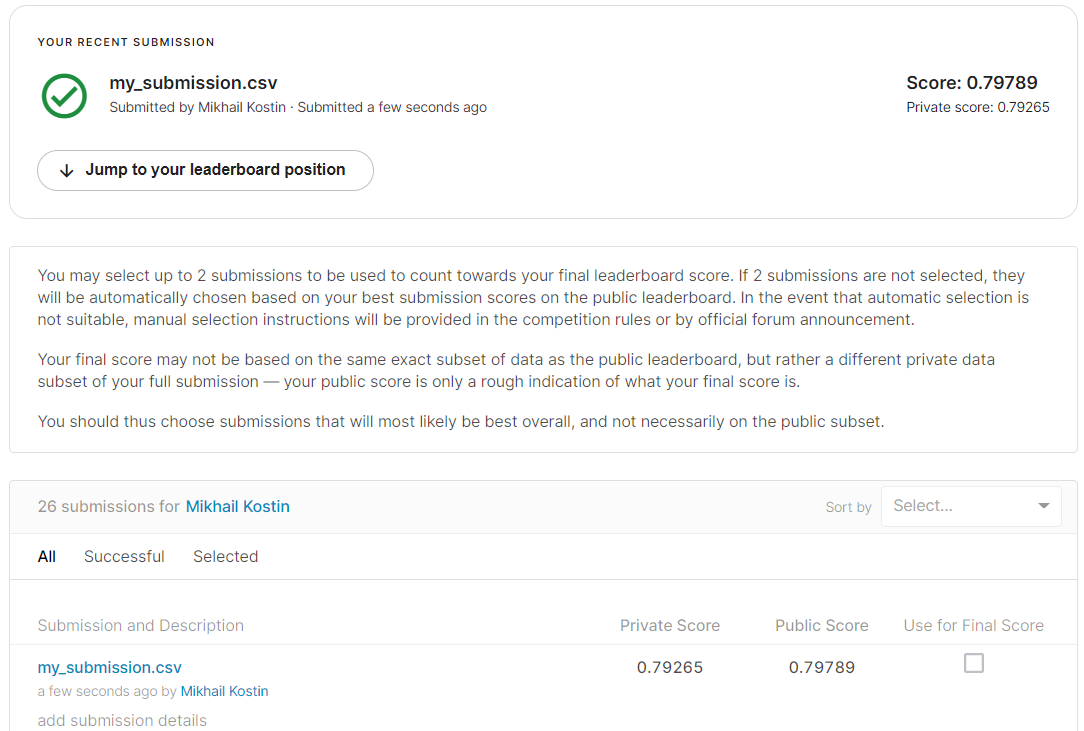

## KNN

Попробуем knn

In [1072]:
from sklearn.model_selection import GridSearchCV

In [516]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}


In [517]:
clf_knn = KNeighborsClassifier(weights='distance', n_jobs=-1)

In [518]:
# Долго
#grid = GridSearchCV(clf_knn, param_grid, cv=10, scoring='accuracy')

In [519]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=KNeighborsClassifier(n_jobs=-1, weights='distance'),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='accuracy')

In [521]:
grid.best_params_

{'n_neighbors': 30}

In [1073]:
clf_knn = KNeighborsClassifier(n_neighbors=30, weights='distance', n_jobs=-1)

In [1083]:
clf_knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=30, weights='distance')

In [1084]:
clf_knn.score(X_val, y_val)

0.76376

In [1085]:
# Обучим knn на всем датасете
clf_knn = KNeighborsClassifier(n_neighbors=30, weights='distance', n_jobs=-1)
clf_knn.fit(X_train_transform, y_tr)

KNeighborsClassifier(n_jobs=-1, n_neighbors=30, weights='distance')

Результат не очень, попробуем объединить результаты логистической регр. и knn

In [1086]:
knn_proba = clf_knn.predict_proba(X_test_transform)

In [1087]:
log_proba = clf.predict_proba(X_test_transform)

In [1088]:
knn_proba

array([[0.9759396 , 0.0240604 ],
       [0.47501747, 0.52498253],
       [0.15833143, 0.84166857],
       ...,
       [1.        , 0.        ],
       [0.41166494, 0.58833506],
       [0.13528116, 0.86471884]])

In [1089]:
log_proba

array([[0.83162486, 0.16837514],
       [0.44397894, 0.55602106],
       [0.0785098 , 0.9214902 ],
       ...,
       [0.84353876, 0.15646124],
       [0.07097196, 0.92902804],
       [0.0530386 , 0.9469614 ]])

In [1090]:
end_proba = []
for knn, log in zip(knn_proba, log_proba):
    end_proba.append(1 if ((knn[1] + log[1])/2)>0.5 else 0)

In [1091]:
ans = np.array(end_proba)[:, np.newaxis]

In [1092]:
subm = pd.read_csv('sample_submission.csv')
subm['Survived'] = ans
subm.to_csv('./my_submission_knn_and_logreg.csv', index=False)

На каггле результат лучше не стал

## Выводы

Лучше всего себя показала Логистическая регрессия с подобранными параметрами, до результата в 0.80 не хватило совсем немного, времени на задание было убито много, если какие-либо идеи или примеры были полезны, надеюсь на небольшую поблажку со стороны проверяющего с его усмотрения)

Discord Mikhail#6829